# 주문추천 로직

## 필요한 패키지(Pandas, Numpy, Scikit-Learn 등)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

### 데이터를 불러오고, 작업에 방해가 되는 스트링 제거

In [4]:
df1 = pd.read_csv("./12월주문자료.CSV",encoding="cp949",engine="python",sep=";")
df1["주문횟수"]=np.repeat(1,len(df1))
ttt=  [x.replace("<","").replace(">","") for x in df1.FC명]
df1["FC명"]=ttt

### 주문횟수, Unique점포수를 사용한 클러스터링 시각화

E:\anaconda\envs\env1\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


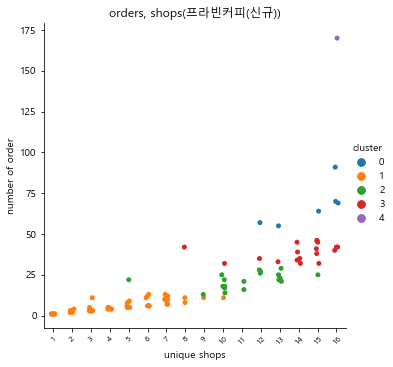

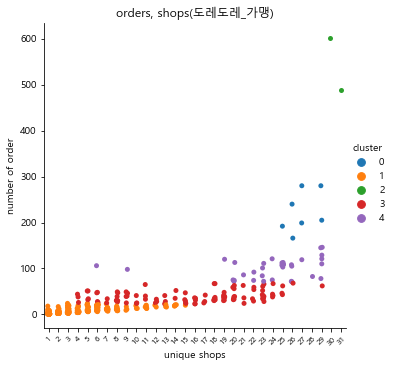

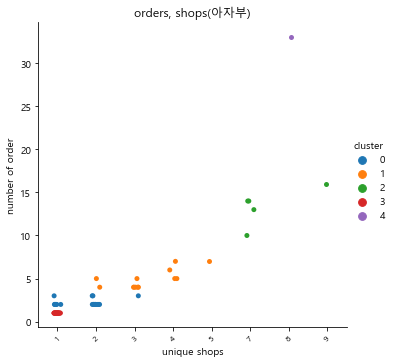

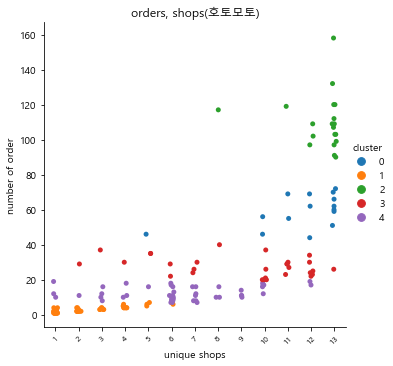

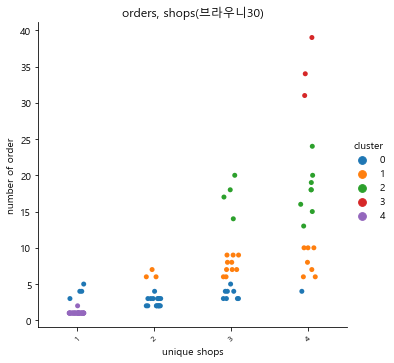

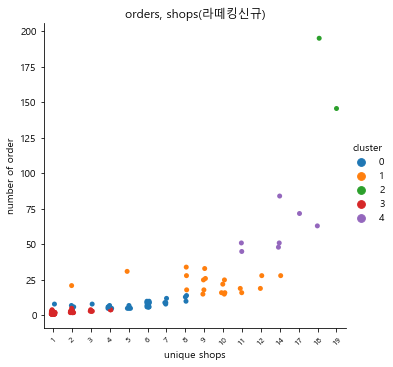

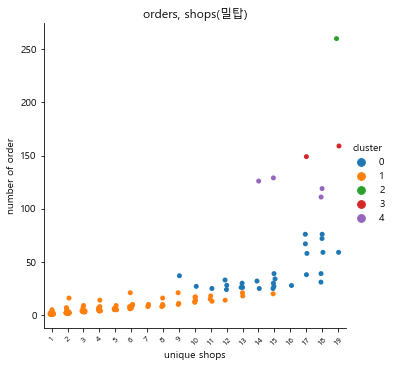

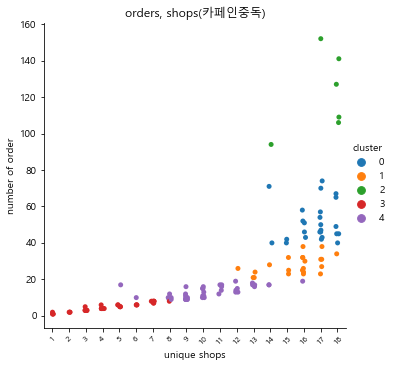

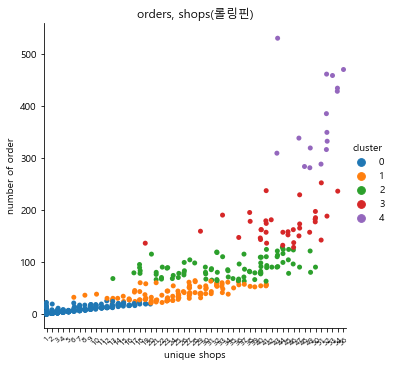

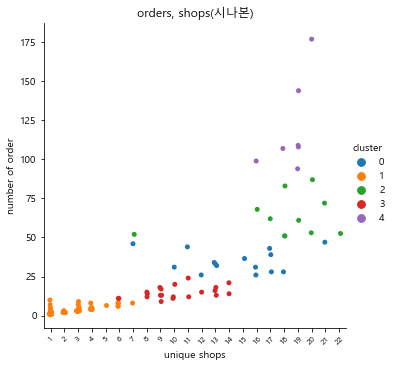

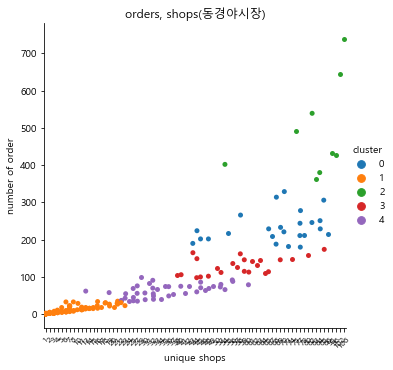

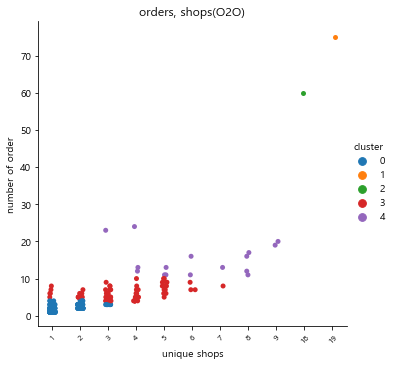

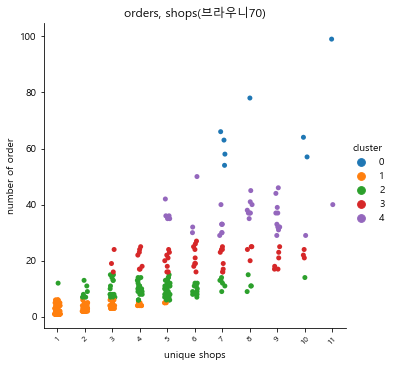

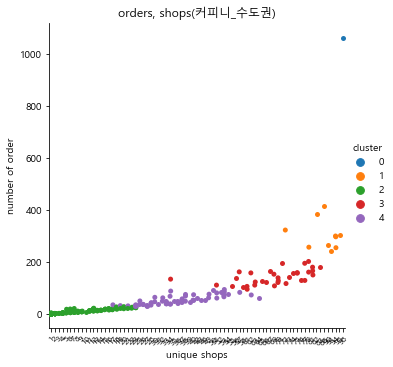

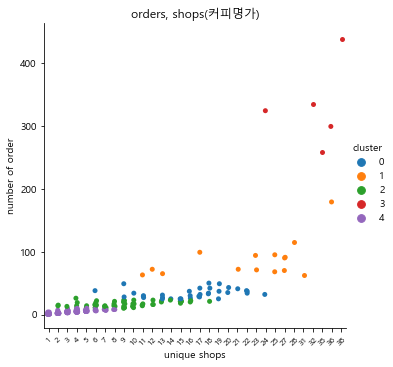

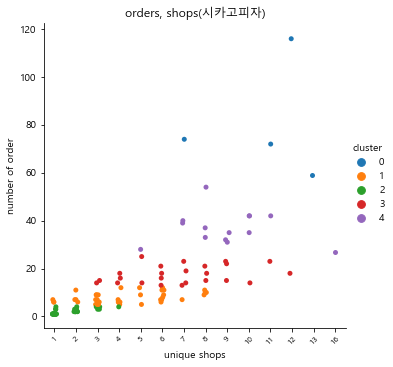

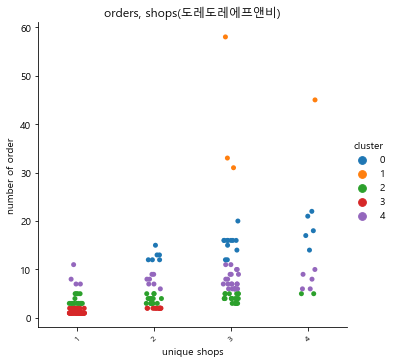

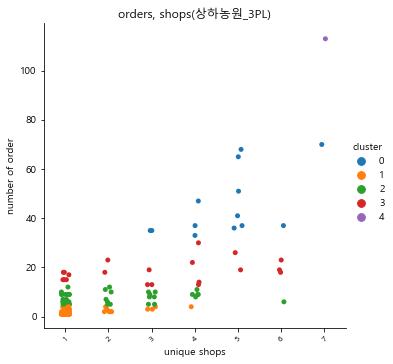

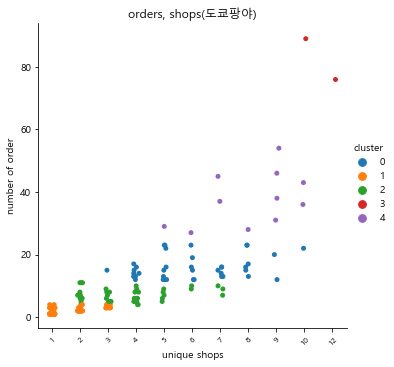

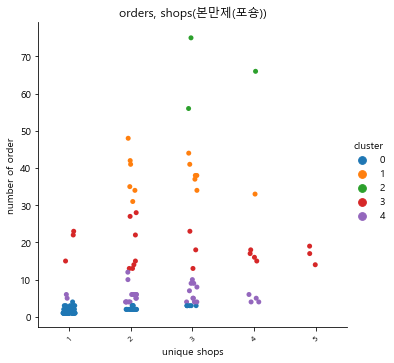

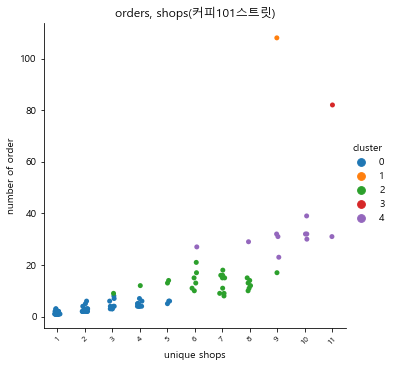

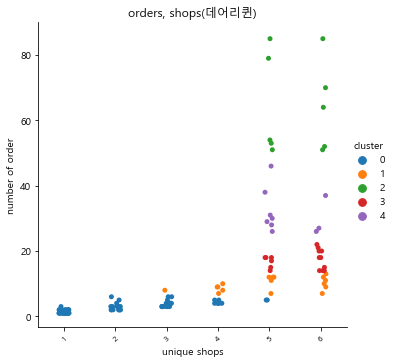

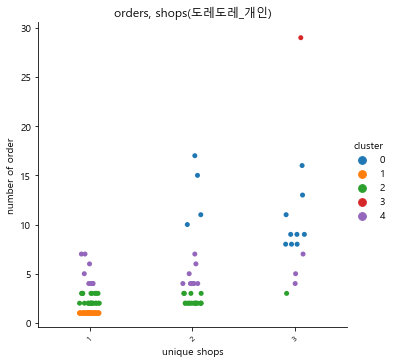

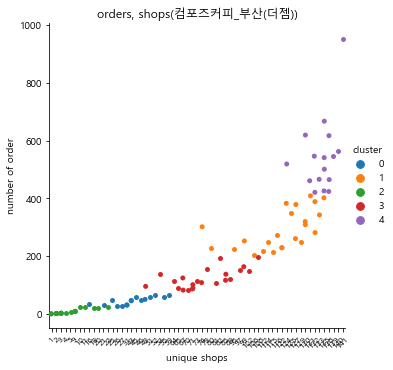

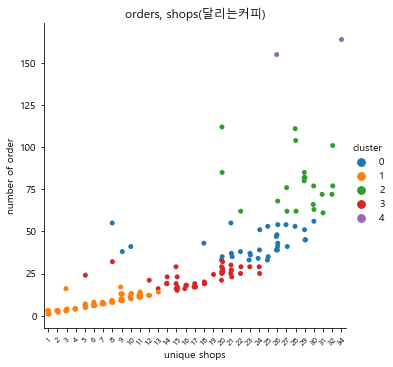

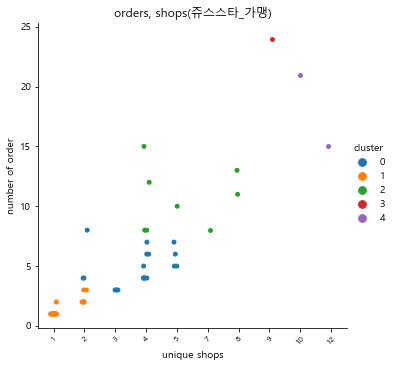

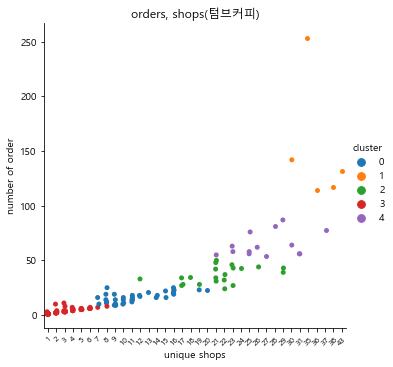

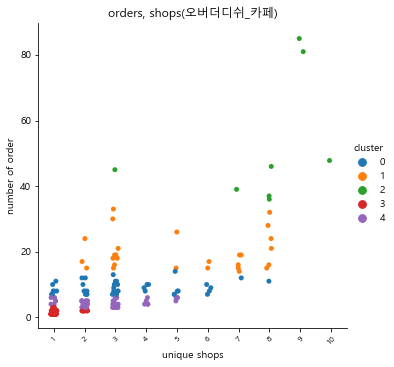

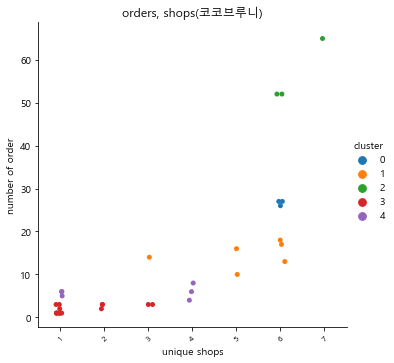

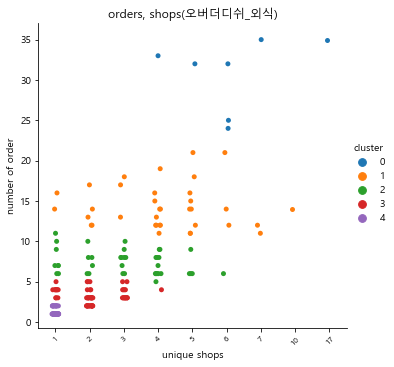

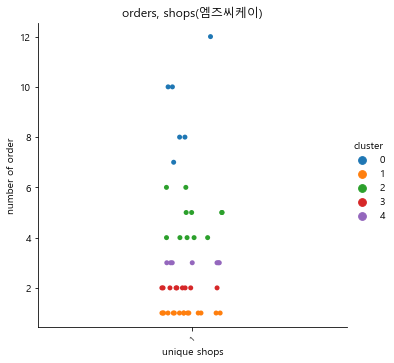

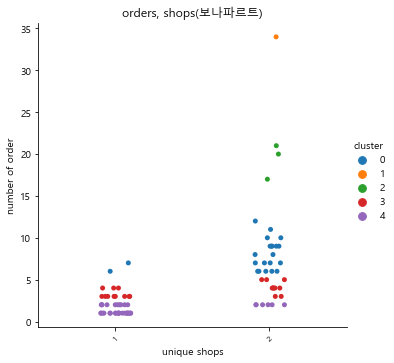

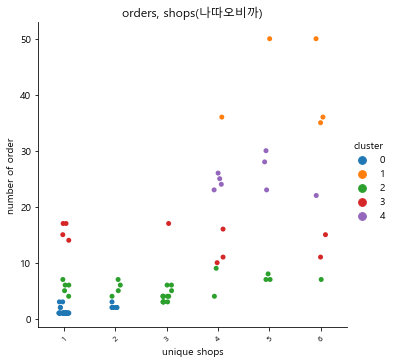

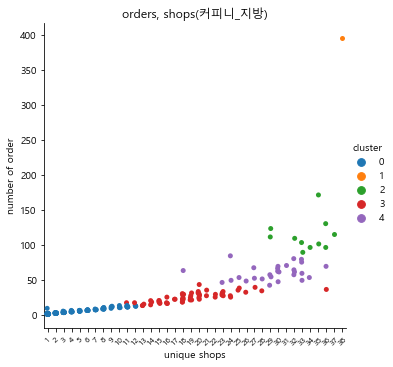

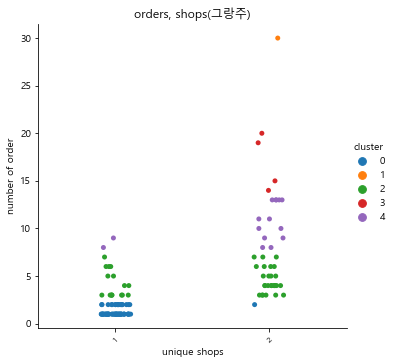

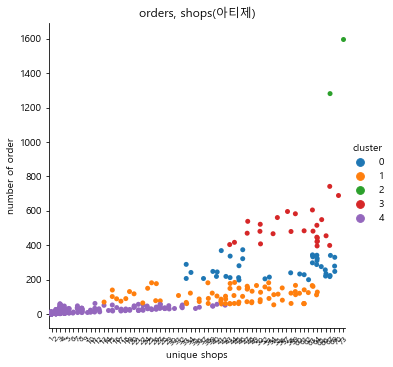

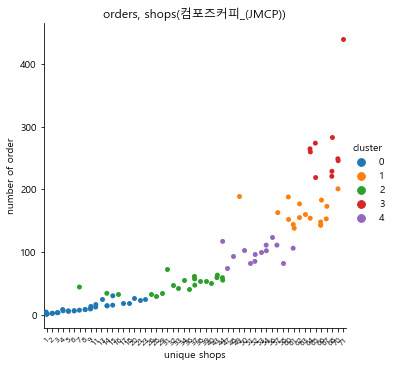

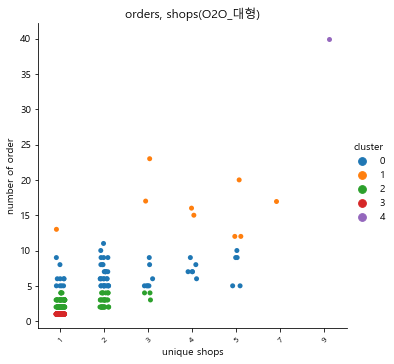

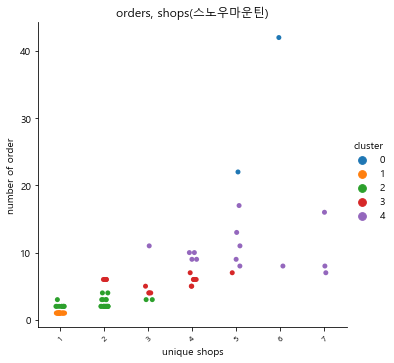

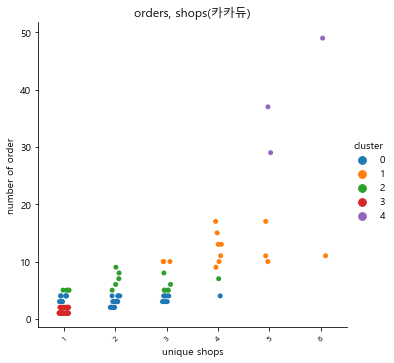

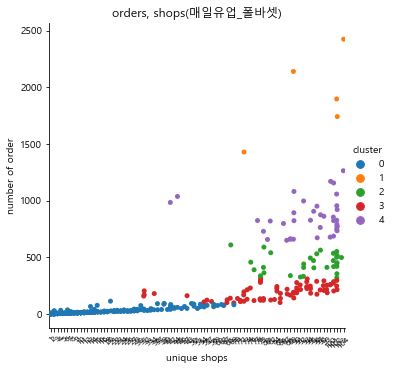

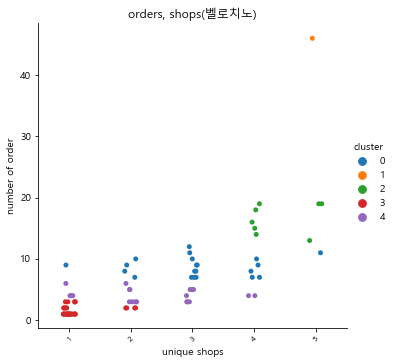

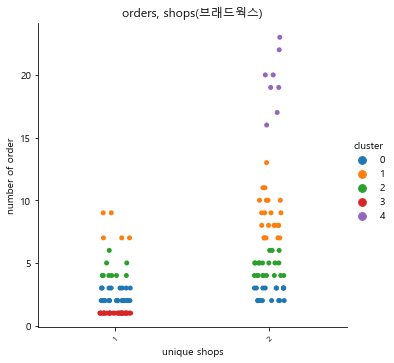

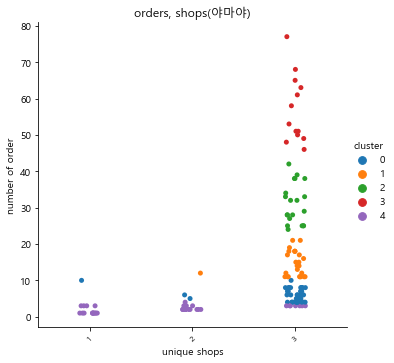

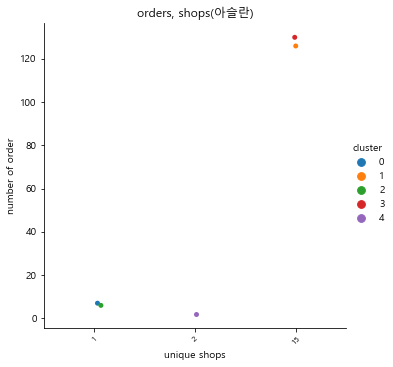

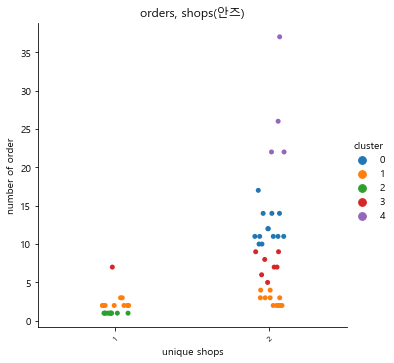

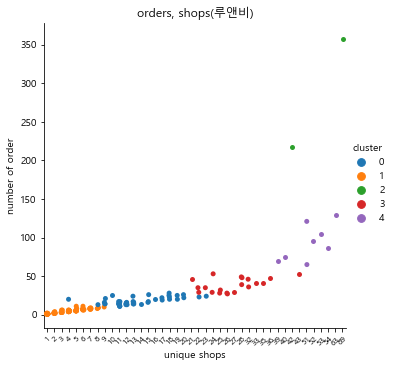

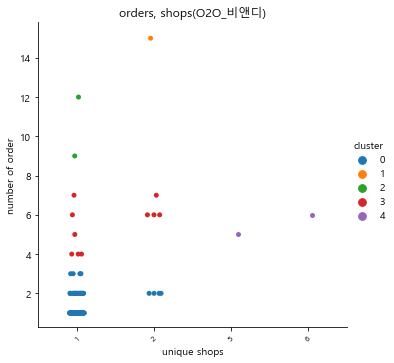

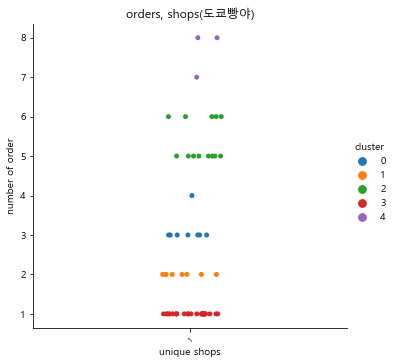

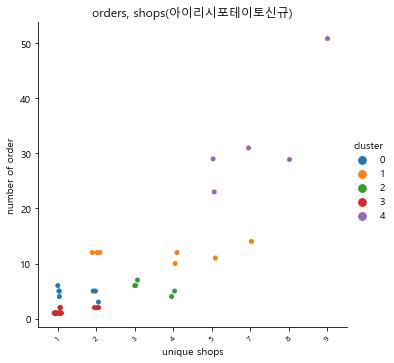

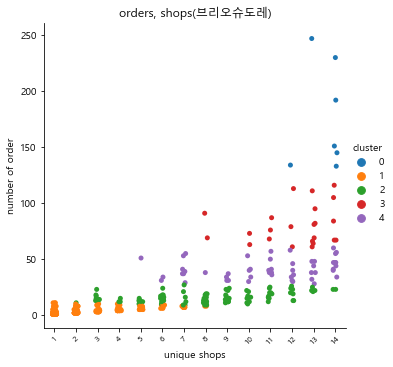

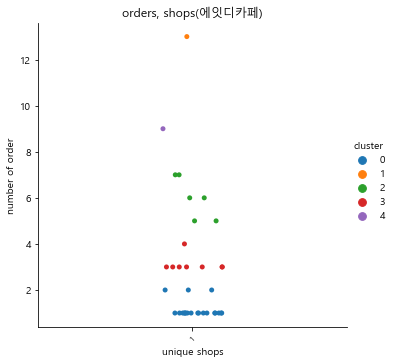

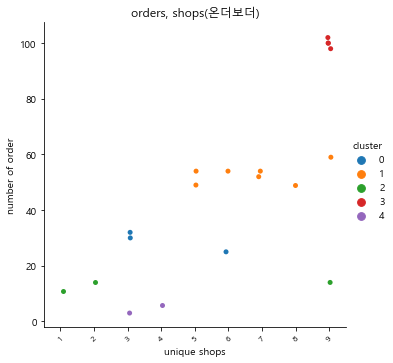

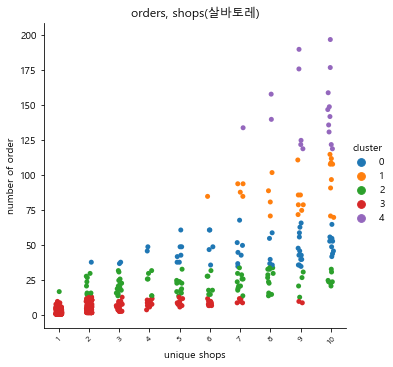

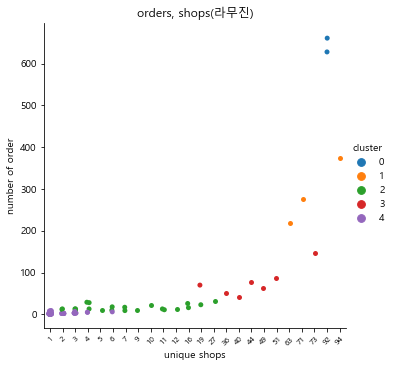

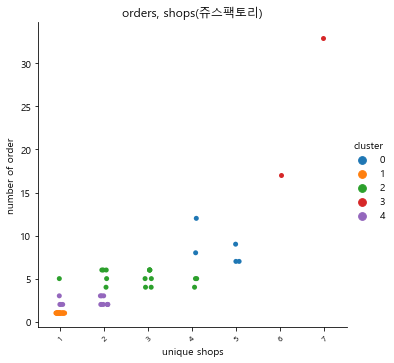

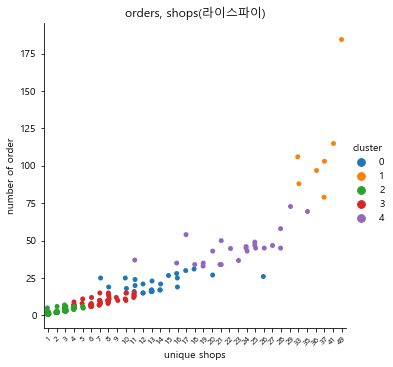

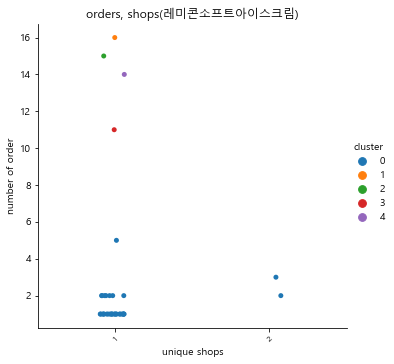

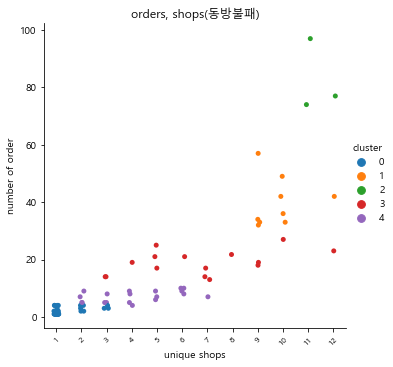

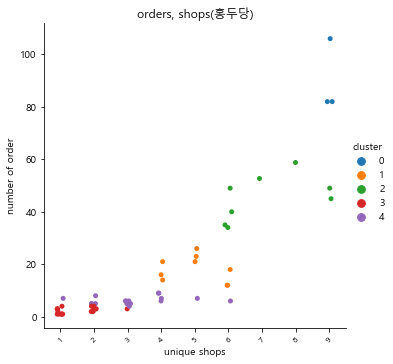

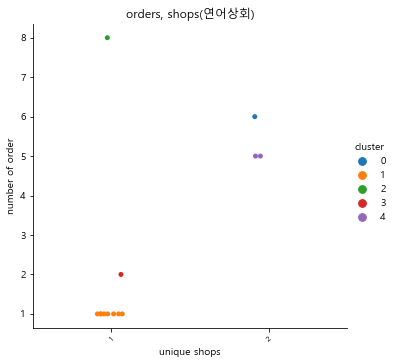

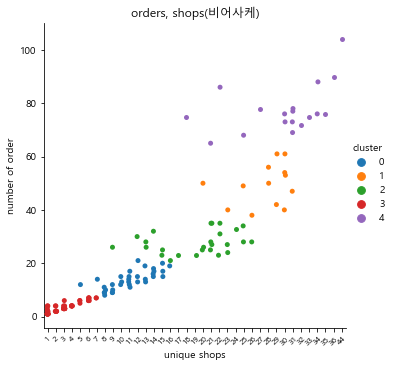

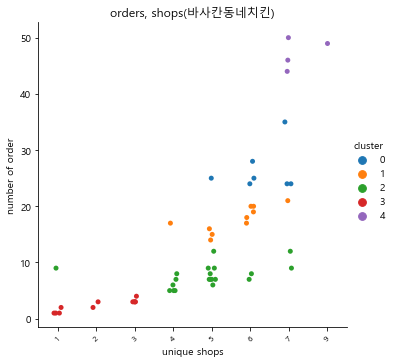

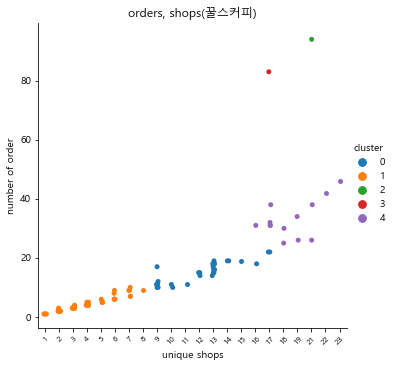

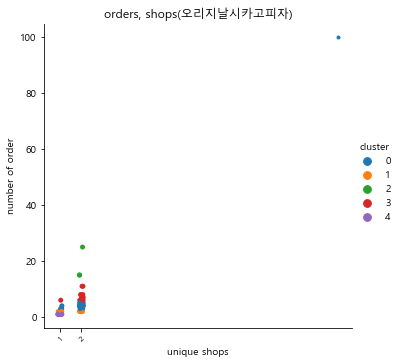

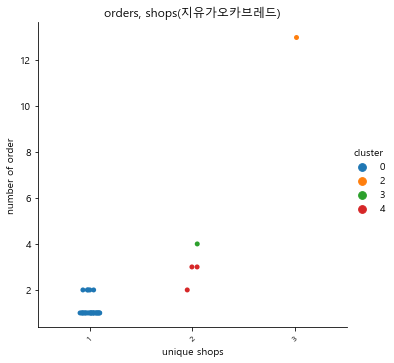

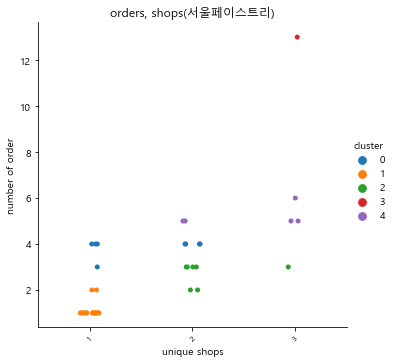

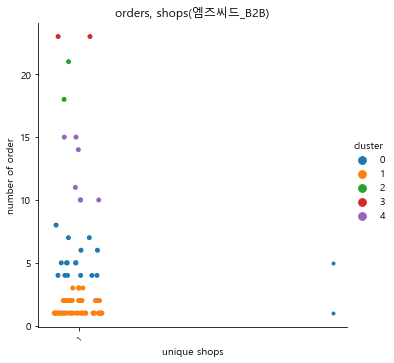

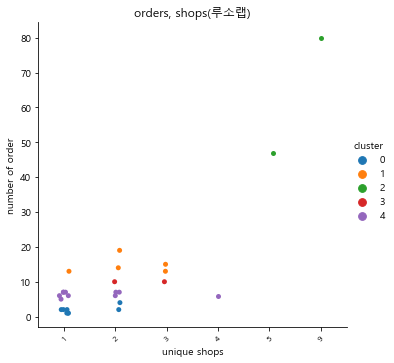

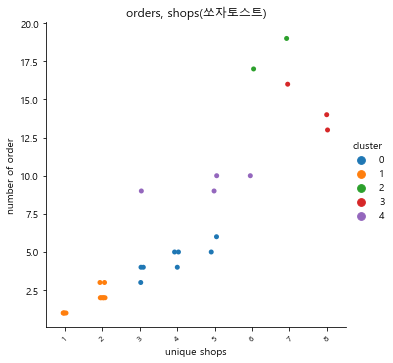

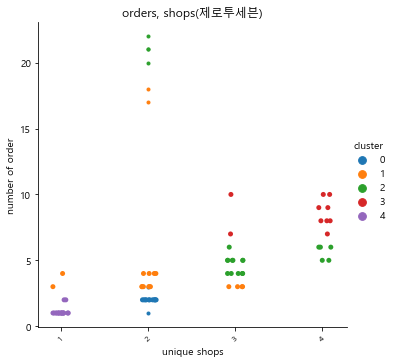

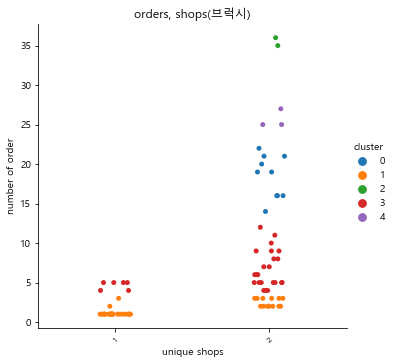

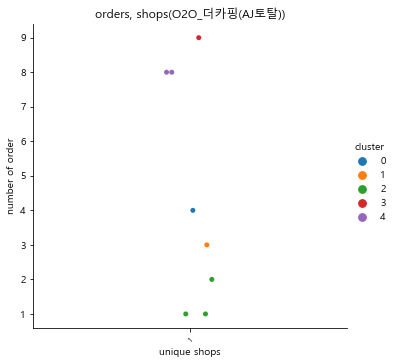

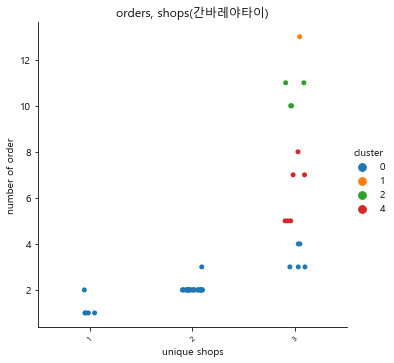

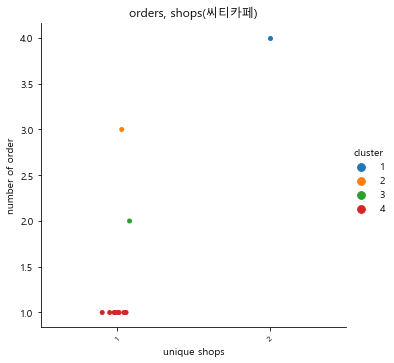

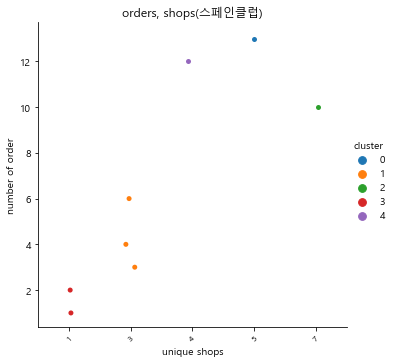

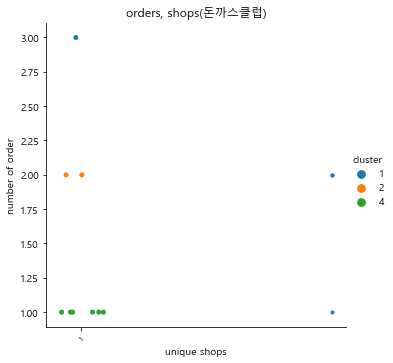

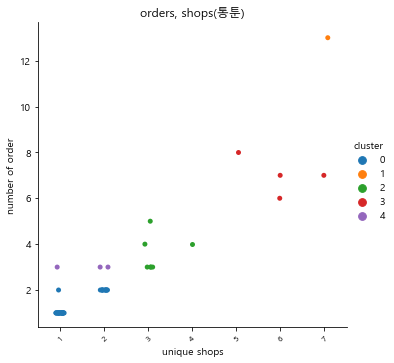

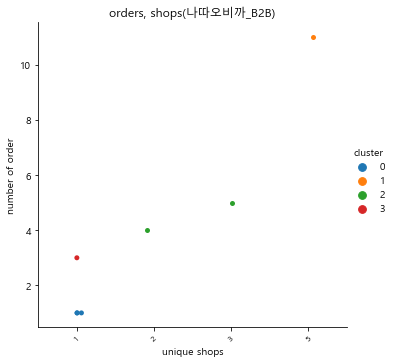

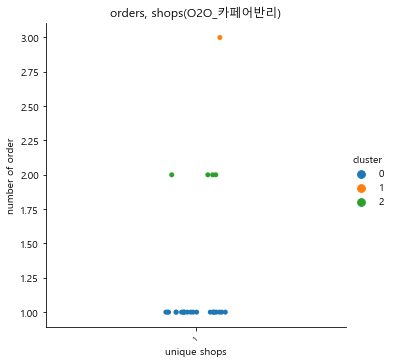

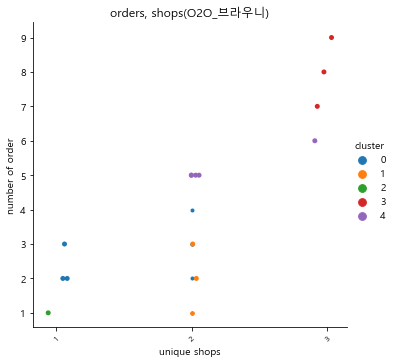

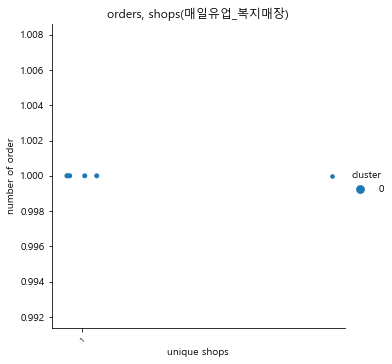

In [65]:
for i in df1.FC명.unique():
    df2 = df1[df1.FC명==i]
    df3 = df2.pivot_table(index="매출처명",columns="SKU명",values="주문횟수",aggfunc=np.sum)
    df4 = pd.DataFrame(df3.sum())
    df4.columns=["주문횟수"]
    unique점포 = []
    for i2 in df3.columns:
        aaa = df3[i2].dropna()
        u1 = len(aaa)
        unique점포 += [u1]
    df4["unique점포"] = unique점포
    X=np.array(df4)
    try:
        model = KMeans(n_clusters=5,init="random",n_init=1,max_iter=100).fit(X)
        df4["cluster"] = model.labels_
        sns.catplot(x="unique점포",y="주문횟수",hue="cluster",data=df4)
        plt.ylabel("number of order")
        plt.xlabel("unique shops")
        plt.xticks(fontsize=8,rotation=45)
        plt.title("orders, shops"+"("+i+")")
        plt.savefig("./"+i+".png",dpi=400)
    except ValueError:
        plt.plot(df4["unique점포"],df4["주문횟수"],".")
        plt.ylabel("number of order")
        plt.xlabel("unique shops")
        plt.xticks(fontsize=8,rotation=45)
        plt.title("orders, shops"+"("+i+")")
        plt.savefig("./"+i+".png",dpi=400)

### FC별로 주문데이터를 나누고 Cossim 계산하여 새로운 DF을 생성

In [70]:
def make_df(x):
    t11 = df1[df1.FC명==x]
    t1 = t11.pivot_table(index="매출처명",columns="SKU명",values="주문횟수",aggfunc=np.sum)
    t2 = pd.DataFrame(t1.sum())
    t2.columns = ["주문횟수"]
    unique점포 = []
    for i2 in t1.columns:
        tt1 = t1[i2].dropna()
        u1 = len(tt1)
        unique점포 += [u1]
    t2["unique점포"] = unique점포
    cosin1 = 1 - pairwise_distances(np.array(t2),metric = "cosine")
    cosin_df = pd.DataFrame(cosin1)
    cosin_df.columns = t2.index
    cosin_df.index = t2.index
    t3 = t11.loc[:,["SKU명","소분류명"]]
    t3 = t3.drop_duplicates()
    new_df = pd.DataFrame({"a":cosin_df.index,"b":cosin_df.iloc[:,0]})
    new_df.columns = ["SKU명","Cossim"]
    new_df2 = ddd.merge(new_df,on = "SKU명", how = "left")
    return(new_df2)

### 같은 소분류, 다른 소분류에 대한 추천 DF의 함수

In [123]:
def rec(x, fc):
    a = make_df(fc)
    cat1 = a.소분류명[a.SKU명==x].unique()[0]
    a = a[a.SKU명!=x]
    cats = a[a.소분류명==cat1].sort_values("Cossim",ascending=False)
    catd = a[a.소분류명!=cat1].sort_values("Cossim",ascending=False)
    return(cats,catd)

### s(ame) 과 d(ifferent)에 추천DF을 할당

In [127]:
s,d=rec('(폴바셋)햄&에그 크로와상 샌드위치_160g/ea','매일유업_폴바셋')

E:\anaconda\envs\env1\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: 'SKU명' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


In [128]:
s

,SKU명,소분류명,Cossim
2,(폴바셋)햄&고다치즈 샌드위치_210g/ea,베이커리 기타,0.994979
359,[폴바셋]촉촉오징어(키즈웰)_36g*16ea/box,베이커리 기타,0.983870
129,슈가콘과자(동산산업)360ea/Box,베이커리 기타,0.950114
393,[폴바셋]대만파인애플케이크(키즈웰)_200g*20ea/box,베이커리 기타,0.929682


In [129]:
d

,SKU명,소분류명,Cossim
478,(엠즈씨드)상하목장아이스밀크믹스스트로베리 1L*10,우유가공품기타,1.000000
53,매일두유99.89_950ml/ea,두유,0.999993
99,포션스무디 망고(IQF)(세미)180g*16ea*box,스무디,0.999992
33,상하목장 아이스밀크믹스다크초콜릿 1L*10EA/BOX,우유가공품기타,0.999990
108,한라봉시럽(우양)_#_500g*10ea/box,시럽,0.999980
20,(폴바셋)초코슈크림 700g*10ea/BOX (엠즈CK),냉동베이커리기타,0.999976
10,(폴바셋)플레인슈크림 700g*10ea/BOX (엠즈CK),냉동베이커리기타,0.999969
132,계란_대란_30알/Box(1판),국)난류,0.999961
265,[폴바셋]싱글빈_르완다 카람비_200g/ea,원두,0.999961
153,[폴바셋]대추농축액(모건푸드)_650g*24ea/box,과일기타,0.999960
